In [1]:
import pandas as pd
import numpy as np

from retrieval_importance import learn_importance, encode_retrievals
from applications.nbr.tifuknn import TIFUKNN
from applications.nbr.data import index_consecutive
from applications.nbr.metrics import hitrate_at_n, recall_at_n, precision_at_n

In [2]:
def utility(retrieval, user_vector):    

    predictions = [(item, weight) for item, weight in enumerate(user_vector) if weight > 0.0]    
    prediction_sorted = sorted(predictions, key=lambda pred: pred[1], reverse=True)
    top_items = [pred[0] for pred in prediction_sorted]
    
    recall = recall_at_n(retrieval['next_basket'], top_items, 5)    
    
    return np.around(recall, decimals=2)

In [3]:
def compare(tifu, users_to_retain, evaluation_baskets, num_eval_users, name):

    hitrates_dirty = []
    recalls_dirty = []
    precisions_dirty = []
    
    hitrates_clean = []
    recalls_clean = []
    precisions_clean = []
    
    for user in range(0, num_eval_users):
        
        next_basket_items = list(evaluation_baskets[evaluation_baskets.user_id==user].item_id)    

        k = 10 # TODO should be a param
        n = 5  # TODO should be a param
        all_neighbors = tifu.retrieve_for(user)
        
        # Original prediction
        prediction = tifu.predict(user, all_neighbors[:k], n)
        
        cleaned_neighbors = [neighbor for neighbor in all_neighbors if neighbor in users_to_retain]
        prediction_clean = tifu.predict(user, cleaned_neighbors[:k], n)

        
        hitrates_dirty.append(hitrate_at_n(next_basket_items, prediction, n))
        recalls_dirty.append(recall_at_n(next_basket_items, prediction, n))     
        precisions_dirty.append(precision_at_n(next_basket_items, prediction, n))             
        
        hitrates_clean.append(hitrate_at_n(next_basket_items, prediction_clean, n))
        recalls_clean.append(recall_at_n(next_basket_items, prediction_clean, n))
        precisions_clean.append(precision_at_n(next_basket_items, prediction_clean, n))  
    
    print(f'{name}, hitrate@5_dirty={np.mean(hitrates_dirty):.5f}, hitrate@5_clean={np.mean(hitrates_clean):.5f}') 
    print(f'{name}, precision@5_dirty={np.mean(precisions_dirty):.5f}, precision@5_clean={np.mean(precisions_clean):.5f}')     
    print(f'{name}, recall@5_dirty={np.mean(recalls_dirty):.5f}, recall@5_clean={np.mean(recalls_clean):.5f}')     

In [4]:
def experiment(seed, num_users, num_eval_users, threshold, all_train_baskets, all_validation_baskets, all_test_baskets, lr = 0.1):
    np.random.seed(seed)

    unique_user_ids = list(all_train_baskets.user_id.unique())
    sampled_users = np.random.choice(unique_user_ids, num_users)
    train_baskets = all_train_baskets[all_train_baskets.user_id.isin(sampled_users)]
    validation_baskets = all_validation_baskets[all_validation_baskets.user_id.isin(sampled_users)]
    test_baskets = all_test_baskets[all_test_baskets.user_id.isin(sampled_users)] 

    index_consecutive('user_id', [train_baskets, validation_baskets, test_baskets])
    index_consecutive('item_id', [train_baskets, validation_baskets, test_baskets])    
    
    tifu = TIFUKNN(train_baskets, k=10, kplus=40)


    retrievals = []
    for user in range(0, num_eval_users):

        next_basket = list(validation_baskets[validation_baskets.user_id==user].item_id)

        neighbors = tifu.retrieve_for(user)
        neighbor_representations = [tifu.representation(neighbor) for neighbor in neighbors]       

        if len(next_basket) > 0:    
            retrievals.append({
                'user': user,
                'next_basket': next_basket,
                'neighbors': neighbors,
                'neighbor_representations': neighbor_representations,
            })    

    encoded_retrievals, mapping = encode_retrievals(retrievals, "neighbors", "neighbor_representations", utility)   

    v = learn_importance(encoded_retrievals, k=10, learning_rate=lr, num_steps=500)

    users_to_retain = set([user for (user, value) in enumerate(v) if value >= threshold])
    users_to_retain.update(range(0, num_eval_users))


    print(f'-----SEED={seed}-----')
    cleaned_train_baskets = train_baskets[train_baskets.user_id.isin(users_to_retain)]    
    print(f'datasize_dirty={len(train_baskets)}, datasize_clean={len(cleaned_train_baskets)}')
    
    compare(tifu, users_to_retain, validation_baskets, num_eval_users, 'validation')
    compare(tifu, users_to_retain, test_baskets, num_eval_users, 'test')        
    return v

In [5]:
all_train_baskets = pd.read_csv("applications/nbr/data/instacart_30k/train_baskets.csv.gz")
all_validation_baskets = pd.read_csv("applications/nbr/data/instacart_30k/valid_baskets.csv")
all_test_baskets = pd.read_csv("applications/nbr/data/instacart_30k/test_baskets.csv") 

In [7]:
for seed in [42, 16, 1812, 1312, 35]:
    experiment(seed, 1000, 100, 0.5, all_train_baskets, all_validation_baskets, all_test_baskets)

-----SEED=42-----
datasize_dirty=157463, datasize_clean=87144
validation, hitrate@5_dirty=0.88000, hitrate@5_clean=0.88000
validation, precision@5_dirty=0.42800, precision@5_clean=0.43400
validation, recall@5_dirty=0.22702, recall@5_clean=0.22959
test, hitrate@5_dirty=0.77000, hitrate@5_clean=0.78000
test, precision@5_dirty=0.36600, precision@5_clean=0.36800
test, recall@5_dirty=0.19187, recall@5_clean=0.19359
-----SEED=16-----
datasize_dirty=156897, datasize_clean=85034
validation, hitrate@5_dirty=0.92000, hitrate@5_clean=0.90000
validation, precision@5_dirty=0.45600, precision@5_clean=0.45000
validation, recall@5_dirty=0.22608, recall@5_clean=0.22487
test, hitrate@5_dirty=0.84000, hitrate@5_clean=0.85000
test, precision@5_dirty=0.40000, precision@5_clean=0.40600
test, recall@5_dirty=0.20532, recall@5_clean=0.20762
-----SEED=1812-----
datasize_dirty=163196, datasize_clean=87367
validation, hitrate@5_dirty=0.78000, hitrate@5_clean=0.76000
validation, precision@5_dirty=0.38200, precisio

In [17]:
def compare_weighted(tifu, users_to_retain, evaluation_baskets, num_eval_users, name, weights):

    hitrates_dirty = []
    recalls_dirty = []
    precisions_dirty = []
    
    hitrates_clean = []
    recalls_clean = []
    precisions_clean = []
    
    for user in range(0, num_eval_users):
        
        next_basket_items = list(evaluation_baskets[evaluation_baskets.user_id==user].item_id)    

        k = 10 # TODO should be a param
        n = 5  # TODO should be a param
        all_neighbors = tifu.retrieve_for(user)
        
        # Original prediction
        prediction = tifu.predict(user, all_neighbors[:k], n)
        
        cleaned_neighbors = [neighbor for neighbor in all_neighbors if neighbor in users_to_retain]
        prediction_clean = tifu.predict_weighted(user, cleaned_neighbors[:k], weights, n)

        
        hitrates_dirty.append(hitrate_at_n(next_basket_items, prediction, n))
        recalls_dirty.append(recall_at_n(next_basket_items, prediction, n))     
        precisions_dirty.append(precision_at_n(next_basket_items, prediction, n))             
        
        hitrates_clean.append(hitrate_at_n(next_basket_items, prediction_clean, n))
        recalls_clean.append(recall_at_n(next_basket_items, prediction_clean, n))
        precisions_clean.append(precision_at_n(next_basket_items, prediction_clean, n))  
    
    print(f'{name}, hitrate@5_dirty={np.mean(hitrates_dirty):.5f}, hitrate@5_clean={np.mean(hitrates_clean):.5f}') 
    print(f'{name}, precision@5_dirty={np.mean(precisions_dirty):.5f}, precision@5_clean={np.mean(precisions_clean):.5f}')     
    print(f'{name}, recall@5_dirty={np.mean(recalls_dirty):.5f}, recall@5_clean={np.mean(recalls_clean):.5f}')    
    
def experiment_weighted(seed, num_users, num_eval_users, threshold, all_train_baskets, all_validation_baskets, all_test_baskets, lr):
    np.random.seed(seed)

    unique_user_ids = list(all_train_baskets.user_id.unique())
    sampled_users = np.random.choice(unique_user_ids, num_users)
    train_baskets = all_train_baskets[all_train_baskets.user_id.isin(sampled_users)]
    validation_baskets = all_validation_baskets[all_validation_baskets.user_id.isin(sampled_users)]
    test_baskets = all_test_baskets[all_test_baskets.user_id.isin(sampled_users)] 

    index_consecutive('user_id', [train_baskets, validation_baskets, test_baskets])
    index_consecutive('item_id', [train_baskets, validation_baskets, test_baskets])    
    
    tifu = TIFUKNN(train_baskets, k=10, kplus=40)


    retrievals = []
    for user in range(0, num_eval_users):

        next_basket = list(validation_baskets[validation_baskets.user_id==user].item_id)

        neighbors = tifu.retrieve_for(user)
        neighbor_representations = [tifu.representation(neighbor) for neighbor in neighbors]       

        if len(next_basket) > 0:    
            retrievals.append({
                'user': user,
                'next_basket': next_basket,
                'neighbors': neighbors,
                'neighbor_representations': neighbor_representations,
            })    

    encoded_retrievals, mapping = encode_retrievals(retrievals, "neighbors", "neighbor_representations", utility)   

    v = learn_importance(encoded_retrievals, k=10, learning_rate=lr, num_steps=100)

    users_to_retain = set([user for (user, value) in enumerate(v) if value >= threshold])
    users_to_retain.update(range(0, num_eval_users))


    print(f'-----SEED={seed}-----')
    cleaned_train_baskets = train_baskets[train_baskets.user_id.isin(users_to_retain)]    
    print(f'datasize_dirty={len(train_baskets)}, datasize_clean={len(cleaned_train_baskets)}')
    
    compare_weighted(tifu, users_to_retain, validation_baskets, num_eval_users, 'validation', v)
    compare_weighted(tifu, users_to_retain, test_baskets, num_eval_users, 'test', v)        
    return v

-----SEED=42-----
datasize_dirty=157463, datasize_clean=86514
validation, hitrate@5_dirty=0.88000, hitrate@5_clean=0.88000
validation, precision@5_dirty=0.42800, precision@5_clean=0.43400
validation, recall@5_dirty=0.22702, recall@5_clean=0.22959
test, hitrate@5_dirty=0.77000, hitrate@5_clean=0.78000
test, precision@5_dirty=0.36600, precision@5_clean=0.37200
test, recall@5_dirty=0.19187, recall@5_clean=0.19502


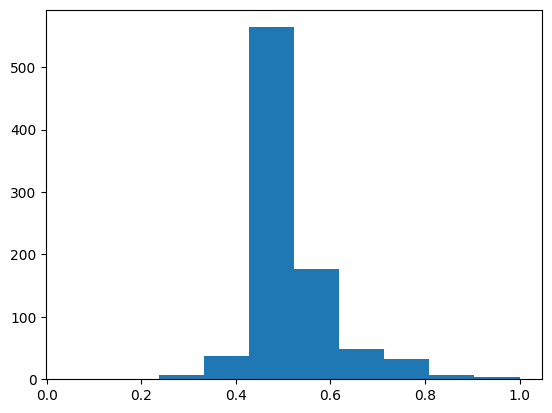

-----SEED=16-----
datasize_dirty=156897, datasize_clean=84092
validation, hitrate@5_dirty=0.92000, hitrate@5_clean=0.91000
validation, precision@5_dirty=0.45600, precision@5_clean=0.45400
validation, recall@5_dirty=0.22608, recall@5_clean=0.22625
test, hitrate@5_dirty=0.84000, hitrate@5_clean=0.85000
test, precision@5_dirty=0.40000, precision@5_clean=0.40400
test, recall@5_dirty=0.20532, recall@5_clean=0.20685


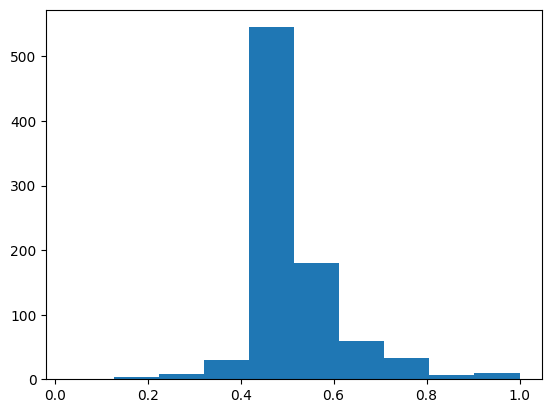

-----SEED=1812-----
datasize_dirty=163196, datasize_clean=86598
validation, hitrate@5_dirty=0.78000, hitrate@5_clean=0.76000
validation, precision@5_dirty=0.38200, precision@5_clean=0.38000
validation, recall@5_dirty=0.19465, recall@5_clean=0.19364
test, hitrate@5_dirty=0.78000, hitrate@5_clean=0.77000
test, precision@5_dirty=0.36400, precision@5_clean=0.36600
test, recall@5_dirty=0.18271, recall@5_clean=0.18620


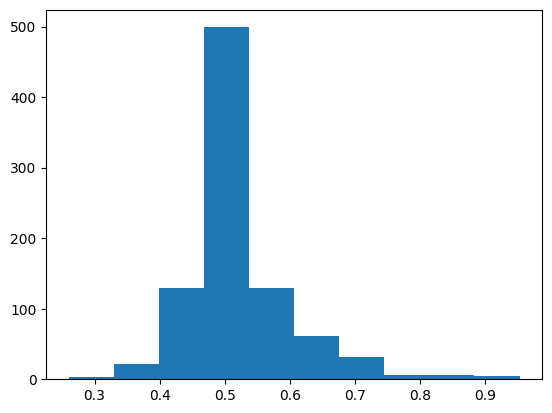

-----SEED=1312-----
datasize_dirty=162644, datasize_clean=79010
validation, hitrate@5_dirty=0.86000, hitrate@5_clean=0.88000
validation, precision@5_dirty=0.42600, precision@5_clean=0.42000
validation, recall@5_dirty=0.21690, recall@5_clean=0.21672
test, hitrate@5_dirty=0.83000, hitrate@5_clean=0.83000
test, precision@5_dirty=0.37200, precision@5_clean=0.36600
test, recall@5_dirty=0.20305, recall@5_clean=0.20014


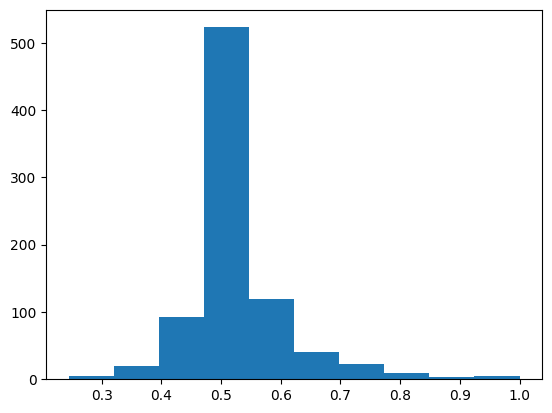

-----SEED=35-----
datasize_dirty=162235, datasize_clean=87155
validation, hitrate@5_dirty=0.75000, hitrate@5_clean=0.76000
validation, precision@5_dirty=0.37400, precision@5_clean=0.37800
validation, recall@5_dirty=0.18795, recall@5_clean=0.18933
test, hitrate@5_dirty=0.85000, hitrate@5_clean=0.84000
test, precision@5_dirty=0.39800, precision@5_clean=0.40200
test, recall@5_dirty=0.20391, recall@5_clean=0.20307


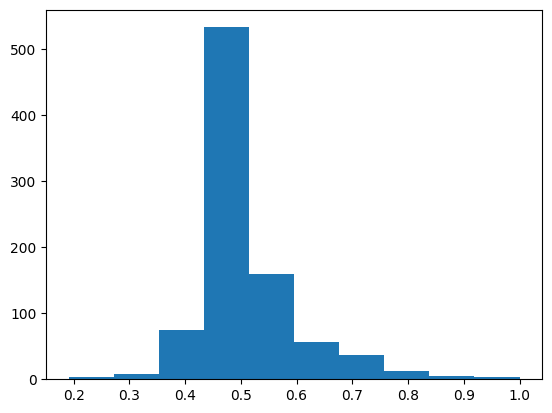

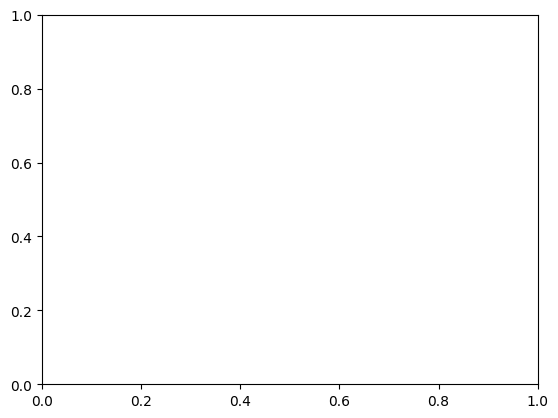

In [18]:
for seed in [42, 16, 1812, 1312, 35]:
    v = experiment_weighted(seed, 1000, 100, 0.5, all_train_baskets, all_validation_baskets, all_test_baskets, 10.0)
    import matplotlib.pyplot as plt
    plt.hist(v)
    plt.show()
    plt.cla()

In [6]:
def compare_mixed(tifu, seed, evaluation_baskets, num_eval_users, name, K, v, repeat_time = 16):

    hitrates_dirty = []
    recalls_dirty = []
    precisions_dirty = []
    
    hitrates_clean = []
    recalls_clean = []
    precisions_clean = []
    
    np.random.seed(seed)
    for _ in range(repeat_time):
        for user in range(0, num_eval_users):

            next_basket_items = list(evaluation_baskets[evaluation_baskets.user_id==user].item_id)    

            k = K # TODO should be a param
            n = 5  # TODO should be a param
            all_neighbors = tifu.retrieve_for(user)

            # Original prediction
            prediction = tifu.predict(user, all_neighbors[:k], n)
            
            random_list = np.random.rand(len(v))
            users_to_retain = set([user for (user, (value, rand)) in enumerate(zip(v, random_list)) if value >= rand])
            users_to_retain.update(range(0, num_eval_users))
            
            cleaned_neighbors = [neighbor for neighbor in all_neighbors if neighbor in users_to_retain]
            prediction_clean = tifu.predict(user, cleaned_neighbors[:k], n)


            hitrates_dirty.append(hitrate_at_n(next_basket_items, prediction, n))
            recalls_dirty.append(recall_at_n(next_basket_items, prediction, n))     
            precisions_dirty.append(precision_at_n(next_basket_items, prediction, n))             

            hitrates_clean.append(hitrate_at_n(next_basket_items, prediction_clean, n))
            recalls_clean.append(recall_at_n(next_basket_items, prediction_clean, n))
            precisions_clean.append(precision_at_n(next_basket_items, prediction_clean, n))  
    
    print(f'{name}, hitrate@5_dirty={np.mean(hitrates_dirty):.5f}, hitrate@5_clean={np.mean(hitrates_clean):.5f}') 
    print(f'{name}, precision@5_dirty={np.mean(precisions_dirty):.5f}, precision@5_clean={np.mean(precisions_clean):.5f}')     
    print(f'{name}, recall@5_dirty={np.mean(recalls_dirty):.5f}, recall@5_clean={np.mean(recalls_clean):.5f}')    
    
def experiment_mixed(seed, num_users, num_eval_users, all_train_baskets, all_validation_baskets, all_test_baskets, K, lr, steps):
    np.random.seed(seed)

    unique_user_ids = list(all_train_baskets.user_id.unique())
    sampled_users = np.random.choice(unique_user_ids, num_users)
    train_baskets = all_train_baskets[all_train_baskets.user_id.isin(sampled_users)]
    validation_baskets = all_validation_baskets[all_validation_baskets.user_id.isin(sampled_users)]
    test_baskets = all_test_baskets[all_test_baskets.user_id.isin(sampled_users)] 

    index_consecutive('user_id', [train_baskets, validation_baskets, test_baskets])
    index_consecutive('item_id', [train_baskets, validation_baskets, test_baskets])    
    
    tifu = TIFUKNN(train_baskets, k=K, kplus=40)


    retrievals = []
    for user in range(0, num_eval_users):

        next_basket = list(validation_baskets[validation_baskets.user_id==user].item_id)

        neighbors = tifu.retrieve_for(user)
        neighbor_representations = [tifu.representation(neighbor) for neighbor in neighbors]       

        if len(next_basket) > 0:    
            retrievals.append({
                'user': user,
                'next_basket': next_basket,
                'neighbors': neighbors,
                'neighbor_representations': neighbor_representations,
            })    

    encoded_retrievals, mapping = encode_retrievals(retrievals, "neighbors", "neighbor_representations", utility)   

    v = learn_importance(encoded_retrievals, k=K, learning_rate=lr, num_steps=steps)
    print(f'-----SEED={seed}-----')
    compare_mixed(tifu, seed, validation_baskets, num_eval_users, 'validation', K, v)
    compare_mixed(tifu, seed, test_baskets, num_eval_users, 'test', K, v)        
    return v

-----SEED=42-----
validation, hitrate@5_dirty=0.88000, hitrate@5_clean=0.88000
validation, precision@5_dirty=0.42800, precision@5_clean=0.42888
validation, recall@5_dirty=0.22702, recall@5_clean=0.22626
test, hitrate@5_dirty=0.77000, hitrate@5_clean=0.77812
test, precision@5_dirty=0.36600, precision@5_clean=0.36825
test, recall@5_dirty=0.19187, recall@5_clean=0.19280


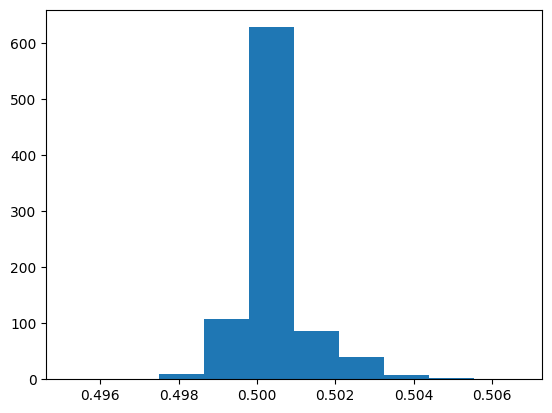

-----SEED=16-----
validation, hitrate@5_dirty=0.92000, hitrate@5_clean=0.90812
validation, precision@5_dirty=0.45600, precision@5_clean=0.45038
validation, recall@5_dirty=0.22608, recall@5_clean=0.22494
test, hitrate@5_dirty=0.84000, hitrate@5_clean=0.83813
test, precision@5_dirty=0.40000, precision@5_clean=0.40300
test, recall@5_dirty=0.20532, recall@5_clean=0.20580


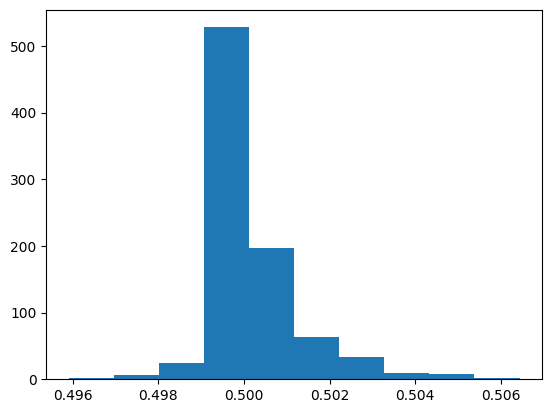

-----SEED=1812-----
validation, hitrate@5_dirty=0.78000, hitrate@5_clean=0.77125
validation, precision@5_dirty=0.38200, precision@5_clean=0.38750
validation, recall@5_dirty=0.19465, recall@5_clean=0.19728
test, hitrate@5_dirty=0.78000, hitrate@5_clean=0.78563
test, precision@5_dirty=0.36400, precision@5_clean=0.37375
test, recall@5_dirty=0.18271, recall@5_clean=0.18842


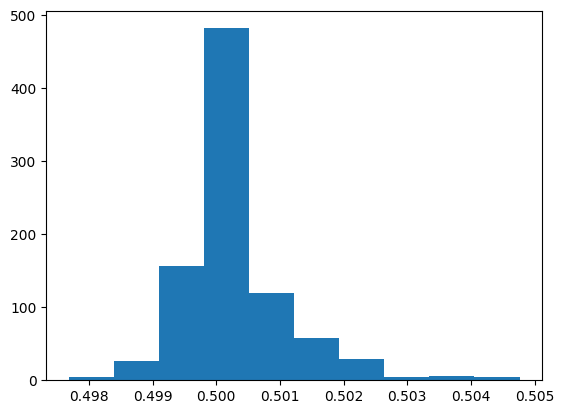

-----SEED=1312-----
validation, hitrate@5_dirty=0.86000, hitrate@5_clean=0.87125
validation, precision@5_dirty=0.42600, precision@5_clean=0.42737
validation, recall@5_dirty=0.21690, recall@5_clean=0.21804
test, hitrate@5_dirty=0.83000, hitrate@5_clean=0.82437
test, precision@5_dirty=0.37200, precision@5_clean=0.36938
test, recall@5_dirty=0.20305, recall@5_clean=0.20298


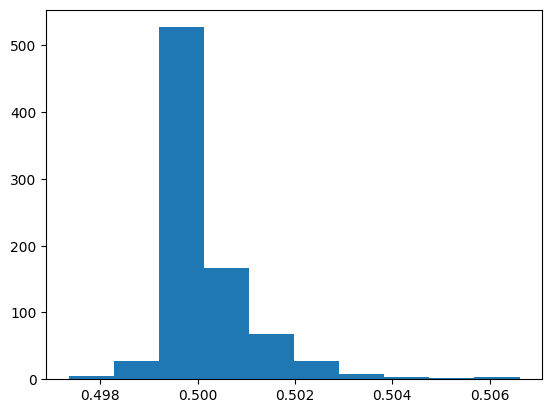

-----SEED=35-----
validation, hitrate@5_dirty=0.75000, hitrate@5_clean=0.74062
validation, precision@5_dirty=0.37400, precision@5_clean=0.37350
validation, recall@5_dirty=0.18795, recall@5_clean=0.18875
test, hitrate@5_dirty=0.85000, hitrate@5_clean=0.84188
test, precision@5_dirty=0.39800, precision@5_clean=0.40000
test, recall@5_dirty=0.20391, recall@5_clean=0.20437


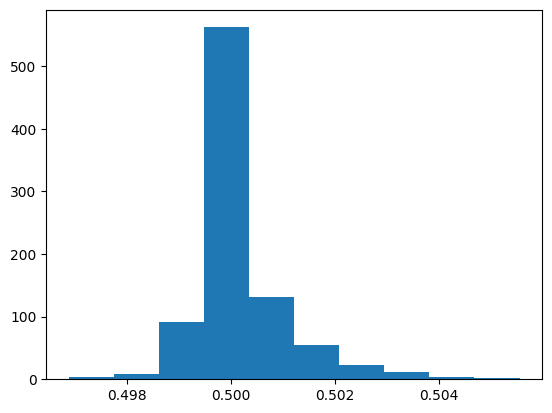

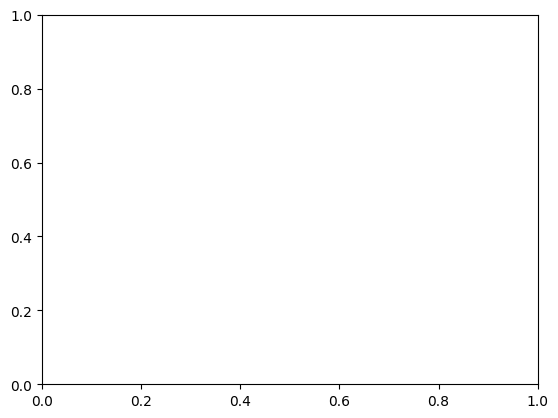

In [7]:
for seed in [42, 16, 1812, 1312, 35]:
    v = experiment_mixed(seed, 1000, 100, all_train_baskets, all_validation_baskets, all_test_baskets, 10, 0.1, 100)
    import matplotlib.pyplot as plt
    plt.hist(v)
    plt.show()
    plt.cla()

In [28]:
print(len(list(all_train_baskets.user_id.unique())))

30000
